# STAT 561 Lab 2: Kernel Methods

### This material was adapted from a previous lab developed by Hunter Klein

## Goals: 
* Review kernel definition and properties of valid kernels 
* Introduce the kernel trick and Mercer's Theorem 
* Kernel Ridge Regression using Sklearn 
* Introduce Gaussian Processes (GPs) as a cool kernel-based method. 

### Additional resources: 
* Murphy's Probabilistic ML Book, chapter 18 on GPs - [prob_ML_book](https://probml.github.io/pml-book/book2.html)
* This amazing post on GPs - [distill_GP_post](https://distill.pub/2019/visual-exploration-gaussian-processes/)
* Gaussian Processes for Machine Learning - Rasmussen & Williams (2006) -- the bible on GPs!
* Sklearn's page on kernel approximation - [sklearn_kernel_approx](https://scikit-learn.org/stable/modules/kernel_approximation.html)

### So, what is a kernel? What properties a kernel MUST have?

Kernel can mean many different things in math, BUT here we are specifically considering **Mercer Kernels**, that is, symmetric positive definite kernels. <br/>
More specifically, a Mercer kernel is any **symmetric** function $\mathcal{K} : \mathcal{X} \times \mathcal{X} \to \mathbb{R}^{+}$, s.t.: <br/>
<br/>
$\sum_{i=1}^N \sum_{j=1}^N \mathcal{K} (\mathbf{x}_i, \mathbf{x}_j) c_i c_j \geq 0$ <br/>
<br/>
with equality iff $c_i=0 \, \forall i$. Put it another way, if I give you $N$ data points and a Mercer kernel $\mathcal{K}(., .)$, we can defined a Gram matrix: <br/>
<br/>
$\mathbf{K} = \left[ 
\begin{array}{ccc}
\mathcal{K}(\mathbf{x}_1, \mathbf{x}_1) & \cdots & \mathcal{K}(\mathbf{x}_1, \mathbf{x}_N) \\
 & \vdots & \\
\mathcal{K}(\mathbf{x}_N, \mathbf{x}_1) & \cdots & \mathcal{K}(\mathbf{x}_N, \mathbf{x}_N) 
\end{array}
\right]$ <br/>
<br/>
which has to be symmetric and positive definite for any set of distinct inputs. There are many, many times of Mercer kernels - for a quick reference on these, check out the [kernel_cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/). <br/>

#### Can you think of an example of a valid kernel? What about an invalid one? (Explain)

**Some (popular) examples of valid kernels**
- Linear Kernel $k(x,y) = x^Ty$ 

- Polynomial Kernel $k(x,y) = (\gamma x^Ty + c_0)^d$ 
    - d is the polynomial degree
    - if c_0 = 0, the kernel is said to be homogeneous 
    
- RBF Kernel $k(x,y) = \exp({\frac{-\lVert x - y \rVert^2}{2\sigma^2}})$
    - Called Gaussian if $y = \bar{x}$
    - $\sigma$ influences tightness of fit, as you can imagine, a low $\sigma$ will induce overfitting
    - Note that in sklearn, this is condensed to $\exp(-\gamma \lVert x - y \rVert^2)$ where $\gamma$ is your tightness hyperparameter 
    
**An invalid kernel**
- Many options here, but here's an example: 
$\mathcal{K}(\mathbf{x, x'}) = \lVert \mathbf{x} - \mathbf{x'}\rVert_2$ <br/>
Eucledian norm is NOT a valid kernel -- Gram Mat is NOT P.D.! 

### Wait, but why are kernels cool/useful? 

#### Mercer's Theorem
First, recall that any P.D. matrix $\mathbf{K}$ can be represented in terms of its eigendecomposition $\mathbf{K} = \mathbf{U^\top \Lambda U}$, where $\mathbf{U}$ is matrix containing the eigenvectors and $\mathbf{\Lambda}$ is a diagonal matrix of eigenvalues $\lambda_i > 0$. Using this decomposition we can write each element of $\mathbf{K}$ as <br/>
<br/>
$k_{ij} = (\mathbf{\Lambda^{\frac{1}{2}}U_{:i}})^\top (\mathbf{\Lambda^{\frac{1}{2}}U_{:j}})$
<br/>
<br/>
and, if we define $\boldsymbol{\phi}(\mathbf{x}_i) = \mathbf{U_{:i}}$, then this becomes: <br/>
<br/>
$k_{ij} = \sum_{m=1}^M \lambda_m \phi_m(\mathbf{x}_i) \phi_m(\mathbf{x}_j)$
<br/>
<br/>
where $M$ is the rank of our kernel $\mathbf{K}$ matrix. That is, we can construct a kernel matrix by performing an inner product of some feature vectors, which are implicitly defined by the eigenvectors of the kernel matrix. And, what's more, we can extend the above to any valid kernel function, not just kernel matrices!! <br/>
To do so, start by defining an eigenfunction $\phi()$ of a kernel $\mathcal{K}$ with some corresponding eigenval $\lambda$ as a function that satisfies: <br/>
<br/>
$\int \mathcal{K}(\mathbf{x, x'})\phi(\mathbf{x})d\mu(\mathbf{x}) = \lambda \phi(\mathbf{x'})$
<br/>
<br/>
Note that, for a given kernel function, its corresponding eigenfunctions are orthogonal to each other: <br/>
<br/>
$\int \phi_i(\mathbf{x})\phi_j(\mathbf{x})d\mu(\mathbf{x}) = \delta_{ij}$
<br/>
where $\delta_{ij}$ is the Kronecker delta function. And, using this definition, we can now state **Mercer's Theorem**, which says that any positive definite kernel function can be represented by the following infinite sum: 
<br/>
<br/>
$\mathcal{K}(\mathbf{x, x'}) = \sum_{m=1}^{\infty} \lambda_m \phi_m(\mathbf{x})\phi_m(\mathbf{x'})$
<br/>
<br/>
So what? Well, now we can replace inner product operations in an explicit (and possibly infinite dimensional) feature space with a call to a kernel function - i.e., we can replace $\mathbf{\phi(x^\top)\phi(x)}$ with $\mathcal{K}(\mathbf{x, x'})$!

#### The kernel trick 
Oftentimes, we wish to work with datasets that aren't linearly seperable in one dimensional space, so it can be helpful to use a mapping function $\Phi(x)$ to a higher dimensional (potentially infinite dimensional even!) space where the data are linearly separable. This trategy is known as **the kernel trick**.  Mercer's theorem (above) gives us some intuition behind why the kernel trick works and why it is so powerful! Additionally, it also allows us to build valid kernels!

#### Some ways to build valid kernels (from existing ones)
##### This is NOT an exhaustive list btw! 
* $k(x,x') = ck_1(x,x')$, where $ c > 0 $ is a constant and $k_1(x,x')$ is a known valid kernel
* $k(x,x') = f(x)k_1(x,x')f(x')$ where $f$ is any function
* $k(x,x') = q(k_1(x,x'))$ where $q$ is a polynomial with nonnegative coefficients
* $k(x,x') = \exp(k_1(x,x'))$
* $k(x,x') = k_1(x,x') + k_2(x,x')$ where $k_1$ and $k_2$ are both known valid kernels
* $k(x,x') = k_1(x,x')k_2(x,x')$
* $k(x,x') = x^TAx$, where $A$ is a symmetric positive semidefinite matrix

### Kernels for Regression
#### 1.0) Kernel Ridge Regression 
$$ \hat{\beta} = \text{argmin}_{\beta}(\lVert Y - \Phi(X)^T\beta \rVert^2 + \lambda_1\lVert \beta \rVert^2)$$ <br/>
<br/>
**Try it yourself:**
Use sklearn's KernelRidge Method to fit a Kernel Ridge Regression to some data using a linear kernel. Plot original data, true function and results of your kernel regression. Is this a good fit?

In [1]:
from sklearn.kernel_ridge import KernelRidge
import numpy as np
import matplotlib.pyplot as plt

#generate data 
X = np.linspace(0,15,100).reshape(-1,1)
y = np.cos(X) + np.random.normal(0,.25,size=X.shape[0]).reshape(-1,1)

In [ ]:
#Your Ans Here 

**Try it yourself:** Do same using polynomial kernels of degrees 2, 4, and 6. Once again, plot data, true function and regression results and comment on fit and its relation to chosen poly degree.

In [ ]:
#Your Ans Here 

**Try it yourself:** Now, use a Gaussian ('rbf') kernel instead. Construct a similar plot and comment on fit 

In [ ]:
#Your Ans Here 

#### Playing with costum kernels in sklearn 
* Note that you can also define your own kernel using sklearn and fit your ridge regression using it!
* Below I show examples of this for a linear and rbf kernels (these are already implemented by default, but goal here is just to show you syntax behind this)
* **Try it yourself:** 
    * Implement a custom kernel using a combination of the linear and rbf kernerls we gave to you? (Hint: check allowed linear combo examples given above!) Use this kernel to fit a Ridge Regression to your data. 
    * Now implement a kernel you know is invalid and trying fitting Ridge Regression with it. What happens? 

In [5]:
from sklearn.kernel_ridge import KernelRidge
import numpy as np
import matplotlib.pyplot as plt

#define your own kernel 

#ex: linear 
def my_kernel(X,Y):
    return np.dot(X, Y.T)

#ex: rbf
def my_kernel_rbf(X,Y,sigma=3):
    phi = np.exp(-np.linalg.norm(X-Y)**2 / (2*sigma**2))
    return phi

In [6]:
#create data as before 
X = np.linspace(0,15,100).reshape(-1,1)
y = np.cos(X) + np.random.normal(0,.25,size=X.shape[0]).reshape(-1,1)

In [7]:
#Your Ans Here 

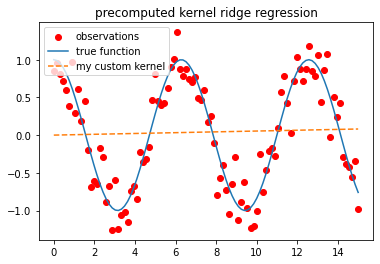

In [10]:
#just show this to them 

from sklearn.kernel_ridge import KernelRidge
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(0,15,100).reshape(-1,1)
y = np.cos(X) + np.random.normal(0,.25,size=X.shape[0]).reshape(-1,1)

linear_Gram = np.dot(X,X.T)


model = KernelRidge(kernel='precomputed')

model.fit(linear_Gram,y)

#In the case for training and test sets, 
#you need to get the gram matrix for the test set as well
y_pred = model.predict(linear_Gram)

plt.scatter(X,y,color='red',label='observations')
plt.plot(X,np.cos(X),label='true function')
plt.plot(X,y_pred,'--',label='my custom kernel')
plt.legend()
plt.title('precomputed kernel ridge regression')
plt.show()

### Gaussian Processes (GPs)

#### What are GPs?
* In a nutshell, GPs are stochastic processes (i.e., collection of RVs indexed by time or space) s.t. every finite collection of such RVs follows a Multivariate Normal Distribution. 
* These are widely used for regression problems on robotics and time-series forecasting, as well as classification. 
* GPs allow us to **place a probability distribution over the space of possible functions which fit our data**. 
    * The mean of this probability distribution represents the most probable characterization of the data.
    * We can use estimated covariance for this distribution to incorporate a notion of confidence in the predictions we obtain from our regression.
    
#### Well what do kernels have to do with GPs?
* When constructing and fitting a GP, one needs to choose a kernel function, which is symmetric, positive definite function. Does this sound familiar? If should! Just recall the Mercer kernels discussion from above. This kernel function will allow us to characterize the covariance matrix for the MVN over our data points...
* More specifically, if we are given a dataset divided into $N$ training points and $N_*$ test points and wish to model these data using a GP, we have: <br/>
<br/>
$\left( 
\begin{array}{c}
\boldsymbol{f}_X \\
\boldsymbol{f}_*
\end{array}
\right) \sim \left(\left( 
\begin{array}{c}
\boldsymbol{\mu}_X \\
\boldsymbol{\mu}_*
\end{array}\right), \left( 
\begin{array}{cc}
\boldsymbol{K}_{X,X} &  \boldsymbol{K}_{X,*}\\
\boldsymbol{K}^\top_{X,*} & \boldsymbol{K}_{*,*}
\end{array}\right) \right)$ <br/>

as the MVN defined over all of our data points. Here, $\boldsymbol{\mu}_X$ and $\boldsymbol{\mu}_*$ are the means of our training and test points, respectively. $\mathbf{K}_{X,X}$ is a $N \times N$ matrix defined by applying our kernel function to the train points. Similarly, $\mathbf{K}_{*,*}$ and $\mathbf{K}_{X,*}$ are $N_* \times N_*$ and $N \times N_*$ matrices defined by applying the kernel function to our train and test points appropriately. <br/>

By choosing a form for our kernel function (e.g., 'rbf') we are implicitly **defining a prior over all possible functions describing our data**. Then, once we see some training data and fit our model to it, we can obtain a posterior distribution over the possible set of functions describing our data, as such:  <br/>
<br/>
$p(\boldsymbol{f}_* | \mathbf{X_*}, \mathcal{D}) = \mathcal{N}(\mathbf{f}_*|\boldsymbol{\mu}_{*|X}, \boldsymbol{\Sigma}_{*|X})$<br/>
$\boldsymbol{\mu}_{*|X} = \boldsymbol{\mu}_* + \mathbf{K^\top}_{X,*}\mathbf{K}^{-1}_{X,X}(\mathbf{f}_X - \boldsymbol{\mu}_X)$ <br/>
$\boldsymbol{\Sigma}_{*|X} = \mathbf{K}_{*, *} - \mathbf{K}^\top_{X, *}\mathbf{K}^{-1}_{X,X} \mathbf{K}_{X,*}$
<br/>
<br/>
Note that there is nothing really new/fancy going on here... These expressions just pop up from knowing that our conditional is Gaussian as well...

And, if we add some uncertainty on training observations as part of our model - i.e., we take $y_n = f(\mathbf{x}_n) + \epsilon_n, \, \epsilon_n \sim \mathcal{N}(0, \sigma_y^2)$, we get: 

<br/>
$\left( 
\begin{array}{c}
\boldsymbol{y} \\
\boldsymbol{f}_*
\end{array}
\right) \sim \left(\left( 
\begin{array}{c}
\boldsymbol{\mu}_X \\
\boldsymbol{\mu}_*
\end{array}\right), \left( 
\begin{array}{cc}
\boldsymbol{K}_{X,X} + \sigma_y^2 \mathbf{I} &  \boldsymbol{K}_{X,*}\\
\boldsymbol{K}^\top_{X,*} & \boldsymbol{K}_{*,*}
\end{array}\right) \right)$ <br/>

as our joint MVN over all data points. And similarly, we can compute the conditional MVN posterior: 

<br/>
$p(\boldsymbol{f}_* | \mathbf{X_*}, \mathcal{D}) = \mathcal{N}(\mathbf{f}_*|\boldsymbol{\mu}_{*|X}, \boldsymbol{\Sigma}_{*|X})$<br/>
$\boldsymbol{\mu}_{*|X} = \boldsymbol{\mu}_* + \mathbf{K^\top}_{X,*}\left(\mathbf{K}_{X,X} + \sigma_y^2 \mathbf{I}\right)^{-1} (\mathbf{y} - \boldsymbol{\mu}_X)$ <br/>
$\boldsymbol{\Sigma}_{*|X} = \mathbf{K}_{*, *} - \mathbf{K}^\top_{X, *} \left(\mathbf{K}_{X,X} + \sigma_y^2 \mathbf{I}\right)^{-1} \mathbf{K}_{X,*}$
<br/>
<br/>

#### Let's play with some code! 

* For this lab we will use tinygp, which is a very lightweight lib for GP implementations (based on JAX) - (https://tinygp.readthedocs.io/en/stable/api/index.html#module-tinygp). 
* **Try it yourself:** Read some of the docs on tinygp above and implement code to construct a GP with an 'rbf' (Gaussian) kernel. Take 3 samples from this prior, then fit model to data (with and without noise) and take another 3 samples from these conditional posteriors.

In [11]:
#you might have to install jax and seaborn 
#in your conda env before proceeding...
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from tinygp import GaussianProcess, kernels
except ModuleNotFoundError:
    %pip install -qqq tinygp
    from tinygp import GaussianProcess, kernels

jax.config.update("jax_enable_x64", True)

In [ ]:
#implement a method to sample from your GP prior 
#complete code below 

def sample_from_prior(key, data):
    """
    Takes samples from GP prior and plots these out.
    Args: 
    key: seed for pseudo random num generator in Jax.
    data: dict. containining keys 'noise', 'n_samples'
    and 'x' containing vals for noise levels, number of 
    samples and original data x.
    """
    #choose an rbf kernel with scale 1 
    kernel = kernels.ExpSquared(scale=1.0) 
    #construct a gp obj using your kernel and the data 
    # and sample from this GP 
    
    ## Your ans here ###
    
    ###################
    
    plt.figure()
    plt.plot(x, samples.T, color=c_0)
    plt.xlabel("$x$")
    plt.ylabel("$f$")
    plt.title('Prior GP Samples')
    sns.despine()

#define color, random seed and data dict 
c_0 = "#1f77b4" 
key = jax.random.PRNGKey(0)
x = jnp.arange(-5, 5.2, 0.2)
data = {"noise": 0.0, "n_samples": 3, "x": x}

#call your method to sample and plot from prior 
sample_from_prior(key, data)

In [ ]:
def sample_from_posterior(key, data):
    """
    Takes samples from conditioned GP posterior and 
    plots these out - showing posterior mean 
    +/- 2std around it.
    Args: 
    key: seed for pseudo random num generator in Jax.
    data: dict. containining keys 'noise', 'n_samples'
    and 'x' containing vals for noise levels, number of 
    samples and original data x.
    """
    #choose an rbf kernel with scale 1 
    kernel = kernels.ExpSquared(scale=1.0)
    
    #construct a gp obj using your kernel and the data 
    #condition it on your train data, and make predictions with it
    #for the test points
    #get posterior mean and std
    
    ## Your ans here ###
    
    ###################

    plt.figure()
    plt.plot(data["x_test"], samples.T, color=c_0)
    plt.scatter(data["x_train"], data["y_train"], color=c_1, zorder=10, s=5)
    plt.fill_between(data["x_test"].flatten(), mean - 2 * std, mean + 2 * std, alpha=0.2)
    plt.xlabel("$x$")
    plt.ylabel("$f$")
    plt.title('Posterior GP samples with {} noise'.format(data['noise']))
    sns.despine()

#generate random seed, train/test data, color for CI band
key = jax.random.PRNGKey(0)
x_train = jnp.array([[-4], [-3], [-2], [-1], [1]])
y_train = jnp.sin(x_train).flatten()

x_test = jnp.expand_dims(jnp.arange(-5, 5.2, 0.2), axis=-1)
c_1 = "#ff7f0e"

#sample from and plot conditioned posterior w/otu obs noise
data = {"noise": 0.0, "n_samples": 3, "x_train": x_train, "y_train": y_train,\
        "x_test": x_test}
sample_from_posterior(key, data)

#sample from and plot conditioned posterior, now with some obs noise
data = {"noise": 0.3, "n_samples": 3, "x_train": x_train, "y_train": y_train, \
        "x_test": x_test}
sample_from_posterior(key, data)

**Challenge:** Can you implement your own rbf kernel GP from scratch? You should incorporate a means to learn the kernel lengthscale and variance params!